# 

In [1]:
import sys, os
sys.path.insert(0, "/home/storage/hans/jax_reco_new")
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import jax.numpy as jnp
from jax.scipy import optimize
import jax
jax.config.update("jax_enable_x64", True)
import optimistix as optx

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from lib.simdata_i3 import I3SimBatchHandlerTFRecord
from lib.geo import center_track_pos_and_time_based_on_data_batched_v
from lib.experimental_methods import get_clean_pulses_fn_v
from lib.network import get_network_eval_v_fn

from likelihood_mpe_padded_input_tests import get_neg_c_triple_gamma_llh
from lib.geo import get_xyz_from_zenith_azimuth, __c
from dom_track_eval import get_eval_network_doms_and_track3 as get_eval_network_doms_and_track
import time

dtype = jnp.float32
eval_network_v = get_network_eval_v_fn(bpath='/home/storage/hans/jax_reco/data/network',
                                       dtype=dtype)
eval_network_doms_and_track = get_eval_network_doms_and_track(eval_network_v, dtype=dtype)

In [2]:
event_id = '10393'

bp = '/home/storage2/hans/i3files/alerts/bfrv2'
tfrecord_corr = os.path.join(bp, f'event_{event_id}_N100_merged_w_energy_loss_preds_from_0_to_10_1st_pulse_sigma_0.7.tfrecord')
tfrecord = os.path.join(bp, f'event_{event_id}_N100_from_0_to_10_1st_pulse.tfrecord')

In [3]:
batches = []

for f in [tfrecord, tfrecord_corr]:
    batch_maker = I3SimBatchHandlerTFRecord(f, batch_size=100)
    batch_iter = batch_maker.get_batch_iterator()
    data, mctruth = batch_iter.next()
    batches.append((jnp.array(data), jnp.array(mctruth)))

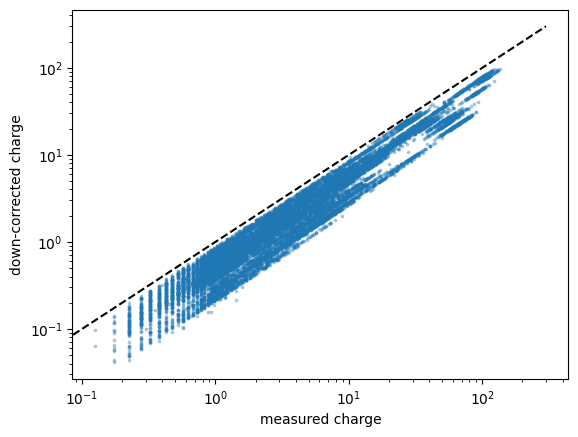

In [4]:
plt.scatter(batches[0][0][..., 4].flatten(), batches[1][0][..., 4].flatten(), s=3, alpha=0.3)
plt.plot([0.0, 300], [0.0, 300], linestyle='dashed', color='black')
plt.xlabel('measured charge')
plt.ylabel('down-corrected charge')
plt.yscale('log')
plt.xscale('log')

In [5]:
# Until LLH has a noise-term, we need to remove crazy early noise pulses
clean_pulses_fn_v = get_clean_pulses_fn_v(eval_network_doms_and_track)

# And set up likelihood for batched processing
neg_llh = get_neg_c_triple_gamma_llh(eval_network_doms_and_track)

In [6]:
scale = 20.0
@jax.jit
def neg_llh_5D(x, args):
        centered_track_time = args[0]
        fitting_event_data = args[1]

        # project back if outside of [0, pi] x [0, 2*pi]
        zenith = x[0] / scale
        azimuth = x[1] / scale
        zenith = jnp.fmod(zenith, 2.0*jnp.pi)
        zenith = jnp.where(zenith < 0, zenith+2.0*jnp.pi, zenith)
        cond = zenith > jnp.pi
        zenith = jnp.where(cond, -1.0*zenith+2.0*jnp.pi, zenith)
        azimuth = jnp.where(cond, azimuth-jnp.pi, azimuth)

        azimuth = jnp.fmod(azimuth, 2.0*jnp.pi)
        azimuth = jnp.where(azimuth < 0, azimuth+2.0*jnp.pi, azimuth)

        projected_dir = jnp.array([zenith, azimuth])
        return neg_llh(projected_dir, x[2:]*scale, centered_track_time, fitting_event_data)

# optimization logic for one event.
def optimize_one_event(data, track_src, centered_track_time, centered_track_pos):
    args=[centered_track_time, data]
    solver = optx.BFGS(rtol=1e-8, atol=1e-4, use_inverse=True)
    x0 = jnp.concatenate([track_src*scale, centered_track_pos/scale])
    best_x = optx.minimise(neg_llh_5D, solver, x0, args=args, throw=False).value
    best_logl = neg_llh_5D(best_x, args=args)
    return best_logl, best_x

# make it work on a batch.
optimize_one_batch = jax.jit(jax.vmap(optimize_one_event, (0, 0, 0, 0), (0, 0)))

# make logl calculation work on a batch.
neg_llh_one_batch = jax.jit(jax.vmap(neg_llh, (0, 0, 0, 0), 0))

def reconstruct_one_batch(data, mctruth):
    data_clean_padded = clean_pulses_fn_v(data, mctruth)
    centered_track_positions, centered_track_times = \
            center_track_pos_and_time_based_on_data_batched_v(data_clean_padded, mctruth)
    
    track_src_v = mctruth[:, 2:4]

    true_logl = neg_llh_one_batch(track_src_v, 
                                  centered_track_positions, 
                                  centered_track_times, 
                                  data_clean_padded)
    
    result_logl, result_x = optimize_one_batch(data_clean_padded,
                                           track_src_v,
                                           centered_track_times,
                                           centered_track_positions)
    return true_logl - result_logl, result_x

In [7]:
def GreatCircleDistance(azi_1, zen_1, azi_2, zen_2):
        ra_1 = azi_1
        ra_2 = azi_2
        dec_1 = np.pi/2.0 - zen_1
        dec_2 = np.pi/2.0 - zen_2
        '''Compute the great circle distance between two events'''
        '''All coordinates must be given in radians'''
        delta_dec = np.abs(dec_1 - dec_2)
        delta_ra = np.abs(ra_1 - ra_2)
        x = (np.sin(delta_dec / 2.))**2. + np.cos(dec_1) *\
            np.cos(dec_2) * (np.sin(delta_ra / 2.))**2.
        return 2. * np.arcsin(np.sqrt(x))

def get_gcd(results):
    scale = 20.0
    reco_zenith, reco_azimuth = results[:, -5]/scale, results[:, -4]/scale
    track_src_v = results[:, 2:4]
    true_zenith, true_azimuth = track_src_v[:, 0], track_src_v[:, 1]
    smpe_zenith, smpe_azimuth = results[:, 8], results[:, 9]
    gcd = np.rad2deg(GreatCircleDistance(true_azimuth, true_zenith, reco_azimuth, reco_zenith))
    gcd_smpe = np.rad2deg(GreatCircleDistance(true_azimuth, true_zenith, smpe_azimuth, smpe_zenith))
    muon_energy = results[:, 0]
    return gcd, gcd_smpe, muon_energy

def get_zen_azi(results):
    scale = 20.0
    reco_zenith, reco_azimuth = results[:, -5]/scale, results[:, -4]/scale
    track_src_v = results[:, 2:4]
    true_zenith, true_azimuth = track_src_v[:, 0], track_src_v[:, 1]
    smpe_zenith, smpe_azimuth = results[:, 8], results[:, 9]
    return track_src_v[:, 0], track_src_v[:, 1], reco_zenith, reco_azimuth, smpe_zenith, smpe_azimuth

def get_hist(results):
    gcd, gcd_smpe, muon_energy = get_gcd(results)
    print(np.amax(gcd), np.amax(gcd_smpe))
    print(np.median(gcd), np.median(gcd_smpe))
    bins = np.linspace(0.0, 3.0, 41)
    cts, _ = np.histogram(gcd, bins=bins)
    cts_smpe, _ = np.histogram(gcd_smpe, bins=bins)
    return cts, bins, cts_smpe

In [8]:
data, mctruth = batches[0]
print(f"processing batch with shape ({data.shape[0]}, {data.shape[1]}, {data.shape[2]})")
tic = time.time()
delta_logl, result_x = reconstruct_one_batch(data, mctruth)
toc = time.time()
y = jnp.column_stack([mctruth, result_x])
print(f"took {toc-tic:.1f}s.")

processing batch with shape (100, 157, 5)
took 12.1s.


In [9]:
TPN_MPE, bins, S_MPE = get_hist(y)

2.6591388043003907 2.6149086474209113
1.1385187143033386 1.112237154906308


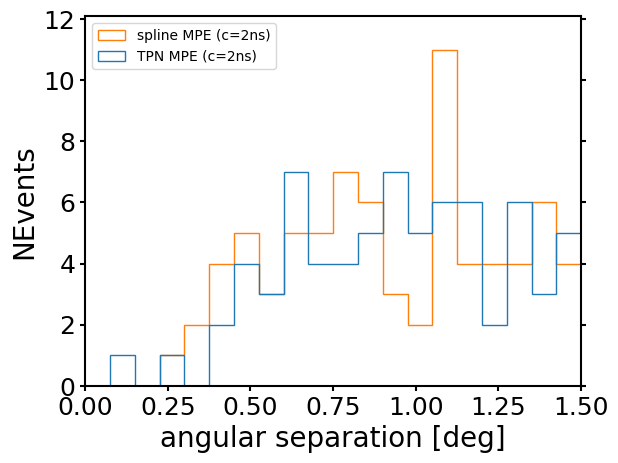

In [10]:
from lib.plotting import adjust_plot_1d
plot_args = {'xlabel':'angular separation [deg]', 
                 'ylabel':'NEvents', 
                 'xlim':[0.0, 1.5], 
                 'ylim':[0.0, np.amax([np.max(TPN_MPE), np.max(S_MPE)])*1.1]}
    
fig, ax = plt.subplots()
plt.hist(0.5*(bins[1:]+bins[:-1]), bins=bins, weights=S_MPE, histtype='step', 
             label='spline MPE (c=2ns)', color='tab:orange')
plt.hist(0.5*(bins[1:]+bins[:-1]), bins=bins, weights=TPN_MPE, histtype='step', 
             label='TPN MPE (c=2ns)', color='tab:blue')
adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.show()

In [11]:
true_zen, true_azi, reco_zen, reco_azi, smpe_zen, smpe_azi = get_zen_azi(y)

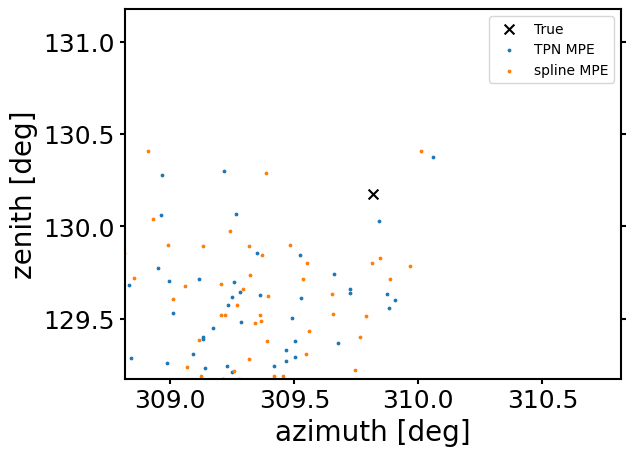

In [12]:
fig, ax = plt.subplots()
plt.scatter(np.rad2deg(true_azi)[0:1], np.rad2deg(true_zen)[0:1], marker='x', color='black', label='True', s=50, zorder=5)
plt.scatter(np.rad2deg(reco_azi), np.rad2deg(reco_zen), label='TPN MPE', s=3, color='tab:blue')
plt.scatter(np.rad2deg(smpe_azi), np.rad2deg(smpe_zen), label='spline MPE', s=3, color='tab:orange')

plt.legend()
d_zen = 1.0
plt.xlim()
plt.ylim()

plot_args = {'xlabel':'azimuth [deg]', 
                 'ylabel':'zenith [deg]', 
                 'xlim':[np.rad2deg(true_azi[0])-d_zen, np.rad2deg(true_azi[0])+d_zen], 
                 'ylim':[np.rad2deg(true_zen[0])-d_zen, np.rad2deg(true_zen[0])+d_zen]}
adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.show()

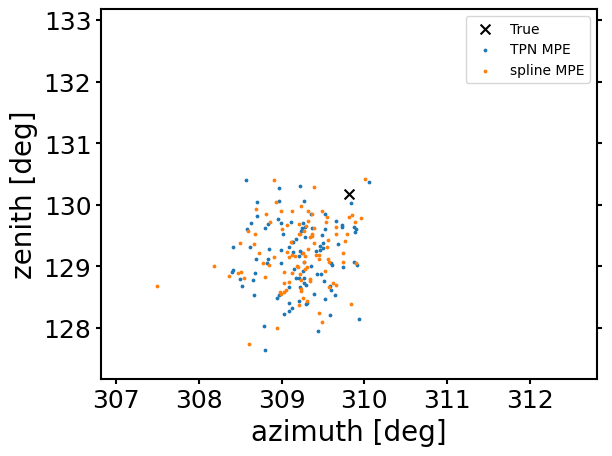

In [13]:
fig, ax = plt.subplots()
plt.scatter(np.rad2deg(true_azi)[0:1], np.rad2deg(true_zen)[0:1], marker='x', color='black', label='True', s=50, zorder=5)
plt.scatter(np.rad2deg(reco_azi), np.rad2deg(reco_zen), label='TPN MPE', s=3, color='tab:blue')
plt.scatter(np.rad2deg(smpe_azi), np.rad2deg(smpe_zen), label='spline MPE', s=3, color='tab:orange')

plt.legend()
d_zen = 3.0
plt.xlim()
plt.ylim()

plot_args = {'xlabel':'azimuth [deg]', 
                 'ylabel':'zenith [deg]', 
                 'xlim':[np.rad2deg(true_azi[0])-d_zen, np.rad2deg(true_azi[0])+d_zen], 
                 'ylim':[np.rad2deg(true_zen[0])-d_zen, np.rad2deg(true_zen[0])+d_zen]}
adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.show()

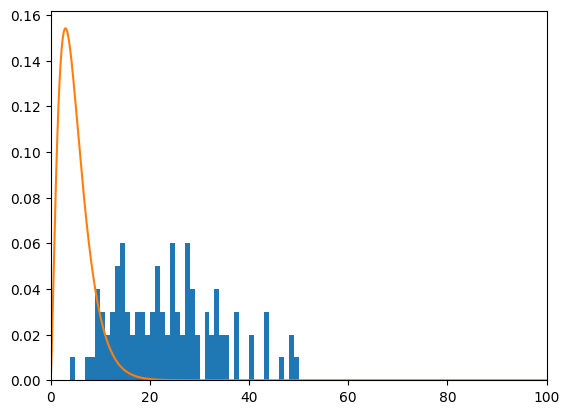

In [14]:
from scipy.stats import chi2
plt.hist(delta_logl, bins=np.linspace(0.0, 1000, 1000), density = True)
xvals = np.linspace(0.0, 100, 10000)
plt.plot(xvals, chi2.pdf(xvals, 5))
plt.xlim([0.0, 100])
plt.show()

In [15]:
data, mctruth = batches[1]

#charge = jnp.floor(jnp.clip(data[..., 4], min=1.0))
charge = jnp.round(data[..., 4]+0.5)
data = jnp.concatenate([data[..., :4], jnp.expand_dims(charge, axis=-1)], axis=-1)

'''
charge = jnp.repeat(jnp.expand_dims(data[..., 4], axis=-1), 5, axis=-1)
ix = charge < 0.01
zeros = jnp.zeros_like(data)
data_ = jnp.where(ix, zeros ,data)
charge = jnp.round(charge + 0.5)[..., 0]
'''

print(f"processing batch with shape ({data.shape[0]}, {data.shape[1]}, {data.shape[2]})")
tic = time.time()
delta_logl, result_x = reconstruct_one_batch(data, mctruth)
toc = time.time()
y = jnp.column_stack([mctruth, result_x])
print(f"took {toc-tic:.1f}s.")

processing batch with shape (100, 157, 5)
took 1.4s.


In [16]:
TPN_MPE, bins, S_MPE = get_hist(y)

1.639891792519111 2.6149086474209113
0.6137903373210889 1.112237154906308


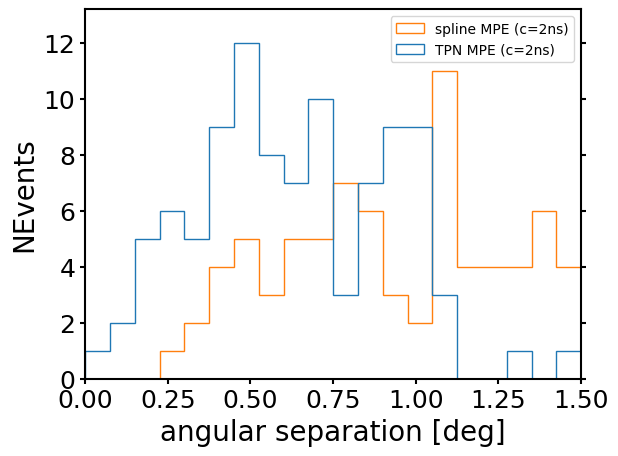

In [17]:
from lib.plotting import adjust_plot_1d
plot_args = {'xlabel':'angular separation [deg]', 
                 'ylabel':'NEvents', 
                 'xlim':[0.0, 1.5], 
                 'ylim':[0.0, np.amax([np.max(TPN_MPE), np.max(S_MPE)])*1.1]}
    
fig, ax = plt.subplots()
plt.hist(0.5*(bins[1:]+bins[:-1]), bins=bins, weights=S_MPE, histtype='step', 
             label='spline MPE (c=2ns)', color='tab:orange')
plt.hist(0.5*(bins[1:]+bins[:-1]), bins=bins, weights=TPN_MPE, histtype='step', 
             label='TPN MPE (c=2ns)', color='tab:blue')
adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.show()

In [18]:
true_zen, true_azi, reco_zen, reco_azi, smpe_zen, smpe_azi = get_zen_azi(y)

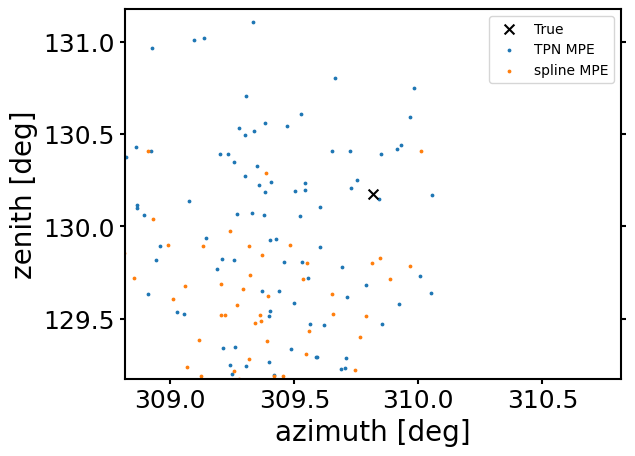

In [19]:
fig, ax = plt.subplots()
plt.scatter(np.rad2deg(true_azi)[0:1], np.rad2deg(true_zen)[0:1], marker='x', color='black', label='True', s=50, zorder=5)
plt.scatter(np.rad2deg(reco_azi), np.rad2deg(reco_zen), label='TPN MPE', s=3, color='tab:blue')
plt.scatter(np.rad2deg(smpe_azi), np.rad2deg(smpe_zen), label='spline MPE', s=3, color='tab:orange')

plt.legend()
d_zen = 1.0
plt.xlim()
plt.ylim()

plot_args = {'xlabel':'azimuth [deg]', 
                 'ylabel':'zenith [deg]', 
                 'xlim':[np.rad2deg(true_azi[0])-d_zen, np.rad2deg(true_azi[0])+d_zen], 
                 'ylim':[np.rad2deg(true_zen[0])-d_zen, np.rad2deg(true_zen[0])+d_zen]}
adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.show()

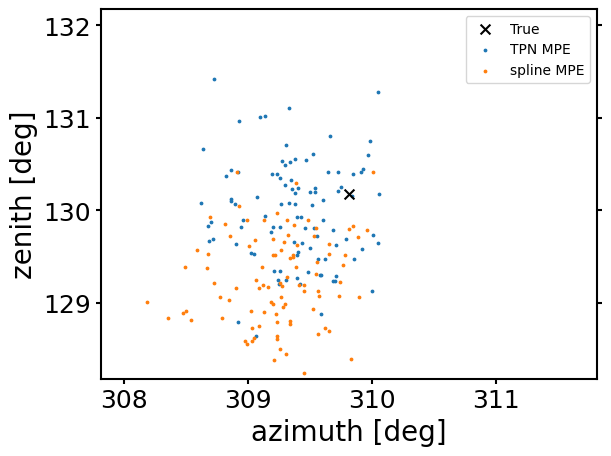

In [20]:
fig, ax = plt.subplots()
plt.scatter(np.rad2deg(true_azi)[0:1], np.rad2deg(true_zen)[0:1], marker='x', color='black', label='True', s=50, zorder=5)
plt.scatter(np.rad2deg(reco_azi), np.rad2deg(reco_zen), label='TPN MPE', s=3, color='tab:blue')
plt.scatter(np.rad2deg(smpe_azi), np.rad2deg(smpe_zen), label='spline MPE', s=3, color='tab:orange')

plt.legend()
d_zen = 2.0
plt.xlim()
plt.ylim()

plot_args = {'xlabel':'azimuth [deg]', 
                 'ylabel':'zenith [deg]', 
                 'xlim':[np.rad2deg(true_azi[0])-d_zen, np.rad2deg(true_azi[0])+d_zen], 
                 'ylim':[np.rad2deg(true_zen[0])-d_zen, np.rad2deg(true_zen[0])+d_zen]}
adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.show()

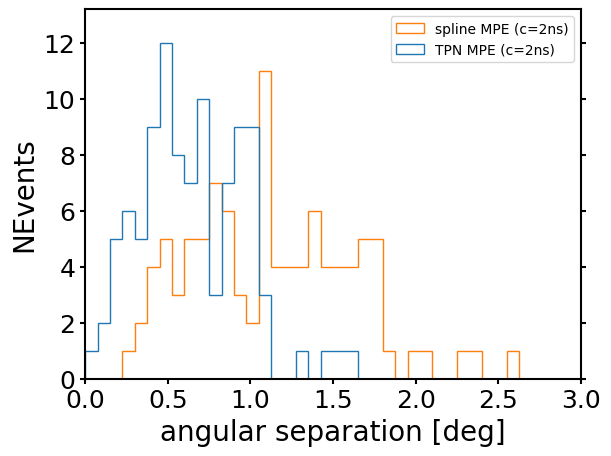

In [21]:
from lib.plotting import adjust_plot_1d
plot_args = {'xlabel':'angular separation [deg]', 
                 'ylabel':'NEvents', 
                 'xlim':[0.0, 3.0], 
                 'ylim':[0.0, np.amax([np.max(TPN_MPE), np.max(S_MPE)])*1.1]}
    
fig, ax = plt.subplots()
plt.hist(0.5*(bins[1:]+bins[:-1]), bins=bins, weights=S_MPE, histtype='step', 
             label='spline MPE (c=2ns)', color='tab:orange')
plt.hist(0.5*(bins[1:]+bins[:-1]), bins=bins, weights=TPN_MPE, histtype='step', 
             label='TPN MPE (c=2ns)', color='tab:blue')
adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.show()

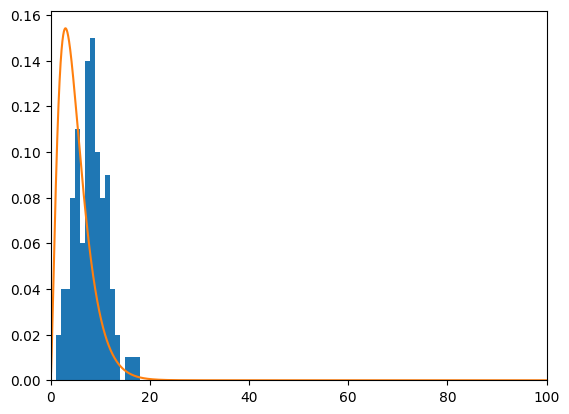

In [22]:
from scipy.stats import chi2
plt.hist(delta_logl, bins=np.linspace(0.0, 1000, 1000), density = True)
xvals = np.linspace(0.0, 100, 10000)
plt.plot(xvals, chi2.pdf(xvals, 5))
plt.xlim([0.0, 100])
plt.show()

In [23]:
chi2.cdf(1.4, 2)

0.5034146962085905